In [1]:
import scipy.stats as sps
from scipy.interpolate import interp1d
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from CMF_Predictor import CMFRecommender

from libmf import mf

Using file found in /home/koltastic/MIPT/m1p/2024-Project-144/.venv/lib/python3.11/site-packages:
/home/koltastic/MIPT/m1p/2024-Project-144/.venv/lib/python3.11/site-packages/libmf.cpython-311-x86_64-linux-gnu.so


In [2]:
def usefulness(c, w, noice):
    return np.arctan(c - w + noice) / np.pi + 0.5

In [12]:
customer_distribution = sps.norm(0.6, 0.2)
w_distribution = sps.norm(0, 0.4)

epsilon = sps.norm(0, 0.05)

class Distribution_Handler:
    def __init__(self, distribution):
        self.distribution = distribution
        
    def rvs(self, size=1):
        if issubclass(type(self.distribution), sps.rv_continuous):
            return self.distribution.rvs(size)
        else:
            return self.distribution.resample(size)[0]
        

In [13]:
def interpol_distribution(sample):
    hst = np.histogram(sample, density=True, bins=200)
    return interp1d(hst[1][:-1], hst[0], kind='linear',
                               fill_value=0.0, bounds_error=False)

In [14]:
def zero_step(model: CMFRecommender, user_info, item_info, topn=52):
    new_feedback = []

    maximal_user, maximal_item = model.get_max_index()
    old_users = model.get_known_users_info().set_index("UserId")
    
    for i in range(topn):
        user_id = np.random.choice(round(maximal_user) - 1)
        for index, item_row in item_info.iterrows():
            deal = sps.bernoulli.rvs(usefulness(old_users.loc[user_id]["F"], item_row["F"], epsilon.rvs()))  # моделируем сделки
            new_feedback.append((user_id, item_row["ItemId"], deal))
    
    for index, user_row in user_info.iterrows():
        w_offered = model.recommend_items_cold(user_row["F"], topn)["ItemId"]
        for w in w_offered:
            deal = sps.bernoulli.rvs(usefulness(user_row["F"], w, epsilon.rvs()))  # моделируем сделки
            new_feedback.append((user_row["UserId"], w, deal))
    
    model.retrain(new_feedback, user_info, item_info)
    return model


In [15]:
def print_distributions(user_info, item_info):
    fig, axs = plt.subplots(ncols=2)
    sns.kdeplot(user_info["F"],ax=axs[0])
    axs[0].set_title("User Distribution")
    sns.kdeplot(data=item_info["F"], ax=axs[1])
    axs[1].set_title("Item Distribution")

In [16]:
def dynamic_system_iterate(model: CMFRecommender, customer_distribution, w_distribution, c_size=10, w_size=10, num_of_steps=5,
                           topn=5, delta=0.2, visualize_distributions=False):
    
    maximal_user, maximal_item = model.get_max_index()
    user_info = pd.DataFrame({"F": customer_distribution.rvs(size=c_size)})  # size = (c_size, c_feature_size) в многомерном случае 
    user_info["UserId"] = np.arange(maximal_user + 1, maximal_user + 1  + c_size)

    item_info = pd.DataFrame({"F": w_distribution.rvs(size=w_size)})  # size = (w_size, w_feature_size) в многомерном случае 
    item_info["ItemId"] = np.arange(maximal_item + 1, maximal_item + 1 + w_size)
    model = zero_step(model, user_info, item_info, topn=topn)
    print(item_info)
    
    if visualize_distributions:
        print_distributions(user_info, item_info)
    
    new_feedback = []
    
    for step in range(1, num_of_steps + 1):
        for index, user_row in user_info.iterrows():
            items_interacted = model.get_interacted_items(user_row["UserId"])
            w_offered = model.recommend_items(user_row["UserId"], item_info['ItemId'], topn=topn, exclude_rated=False)["ItemId"]
            for w in w_offered:
                deal = sps.bernoulli.rvs(usefulness(user_row["F"], w, epsilon.rvs()))  # моделируем сделки
                new_feedback.append((user_row["UserId"], w, deal))
        model.retrain(new_feedback, pd.DataFrame(), pd.DataFrame())
    
    
    # смена распределения
    new_feedback_df = pd.DataFrame(new_feedback, columns=['UserId', 'ItemId', 'Feedback'])
    new_feedback_df["Feedback"] += delta
    grouped_users = new_feedback_df.groupby('UserId')['Feedback'].mean().reset_index()
    # probabilities_users = grouped_users['Feedback'] / grouped_users['Feedback'].sum()
    user_info = user_info.merge(grouped_users, how="inner", on='UserId')
    print("---------USER INFO----------------")
    print(user_info)
    print("-------------------------------------")
    
    customer_distribution = Distribution_Handler(sps.gaussian_kde(user_info["F"], weights=user_info['Feedback']))
    grouped_items = new_feedback_df.groupby('ItemId')['Feedback'].mean().reset_index()
    # probabilities_items = grouped_items['ItemId'] / grouped_items['ItemId'].sum()
    # grouped_items['Feedback'] += delta
    
    
    item_info = item_info.merge(grouped_items, how="inner", on='ItemId')
    print("---------ITEM INFO----------------")
    print(item_info)
    print("-------------------------------------")
    
    w_distribution = Distribution_Handler(sps.gaussian_kde(item_info["F"], weights=item_info['Feedback']))

    return customer_distribution, w_distribution, new_feedback



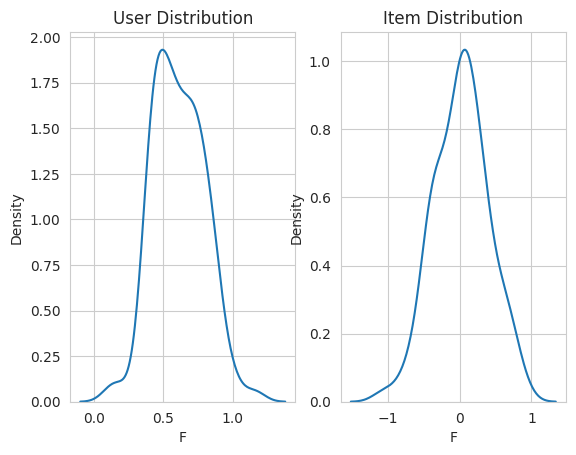

In [17]:
user_info = pd.DataFrame({"F": customer_distribution.rvs(size=100)}) # генерим датасет для нулевой итерации
user_info["UserId"] = np.arange(100)

item_info = pd.DataFrame({"F": w_distribution.rvs(size=100)})
item_info["ItemId"] = np.arange(100)
feedback = []

print_distributions(user_info, item_info)

for i, user_row in user_info.iterrows():
    for j, item_row in item_info.iterrows():
        deal = sps.bernoulli.rvs(usefulness(user_row["F"], item_row["F"], epsilon.rvs()))
        feedback.append((user_row["UserId"], item_row["ItemId"], deal))
model = CMFRecommender()
model.fit(feedback, user_info, item_info)

In [18]:
new_cust_distr, new_w_distr = customer_distribution, w_distribution

          F  ItemId
0  0.113038   100.0
1  0.041550   101.0
2  0.333807   102.0
3  0.263856   103.0
4  0.509532   104.0
5 -0.399303   105.0
6  0.168070   106.0
7  0.215559   107.0
8 -0.748419   108.0
9 -0.157785   109.0
---------USER INFO----------------
          F  UserId  Feedback
0  0.438350   100.0       0.2
1  0.841370   101.0       0.2
2  0.371944   102.0       0.2
3  0.540118   103.0       0.2
4  0.501285   104.0       0.2
5  0.569577   105.0       0.2
6  0.399595   106.0       0.2
7  0.502888   107.0       0.2
8  0.516883   108.0       0.2
9  0.049392   109.0       0.2
-------------------------------------
---------ITEM INFO----------------
          F  ItemId  Feedback
0  0.113038   100.0       0.2
1  0.041550   101.0       0.2
2  0.333807   102.0       0.2
3  0.263856   103.0       0.2
4  0.509532   104.0       0.2
5 -0.399303   105.0       0.2
6  0.168070   106.0       0.2
7  0.215559   107.0       0.2
8 -0.748419   108.0       0.2
9 -0.157785   109.0       0.2
------------

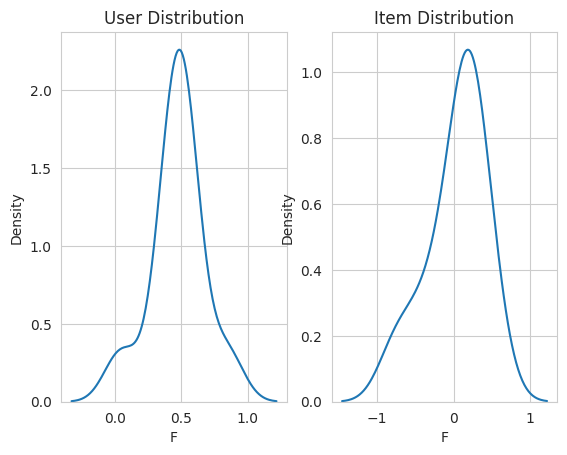

In [19]:
new_cust_distr, new_w_distr, _ = dynamic_system_iterate(model, new_cust_distr, new_w_distr, visualize_distributions=True)

0
          F  ItemId
0 -0.400951   110.0
1 -0.122230   111.0
2  0.102484   112.0
3 -0.985474   113.0
4 -0.143091   114.0
5  0.260770   115.0
6  0.543154   116.0
7  0.006476   117.0
8  0.540351   118.0
9  0.403618   119.0
---------USER INFO----------------
          F  UserId  Feedback
0  0.309548   110.0       0.2
1  0.443154   111.0       0.2
2  0.539872   112.0       0.2
3  0.426663   113.0       0.2
4  0.525013   114.0       0.2
5  0.923977   115.0       0.2
6  0.254135   116.0       0.2
7  0.534953   117.0       0.2
8  0.494000   118.0       0.2
9 -0.024923   119.0       0.2
-------------------------------------
---------ITEM INFO----------------
          F  ItemId  Feedback
0 -0.400951   110.0       0.2
1 -0.122230   111.0       0.2
2  0.102484   112.0       0.2
3 -0.985474   113.0       0.2
4 -0.143091   114.0       0.2
5  0.260770   115.0       0.2
6  0.543154   116.0       0.2
7  0.006476   117.0       0.2
8  0.540351   118.0       0.2
9  0.403618   119.0       0.2
----------

The latent factors contain NAN values


---------USER INFO----------------
          F  UserId  Feedback
0  0.326592   120.0       0.2
1  0.469689   121.0       0.2
2  0.187468   122.0       0.2
3  0.514117   123.0       0.2
4  0.848142   124.0       0.2
5  0.434149   125.0       0.2
6  0.495462   126.0       0.2
7  0.506597   127.0       0.2
8  0.048959   128.0       0.2
9  0.379455   129.0       0.2
-------------------------------------
---------ITEM INFO----------------
          F  ItemId  Feedback
0 -0.518730   120.0       0.2
1  0.049552   121.0       0.2
2 -0.259210   122.0       0.2
3  0.289684   123.0       0.2
4  0.148225   124.0       0.2
5  0.219703   125.0       0.2
6  0.035070   126.0       0.2
7 -0.311892   127.0       0.2
8  0.677378   128.0       0.2
9 -1.390614   129.0       0.2
-------------------------------------
2


ValueError: Unexpected error.

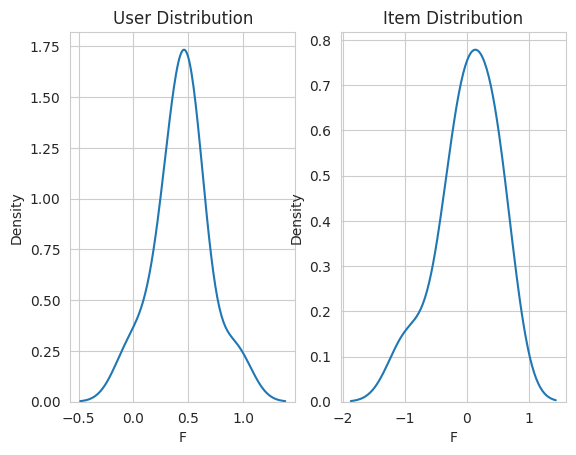

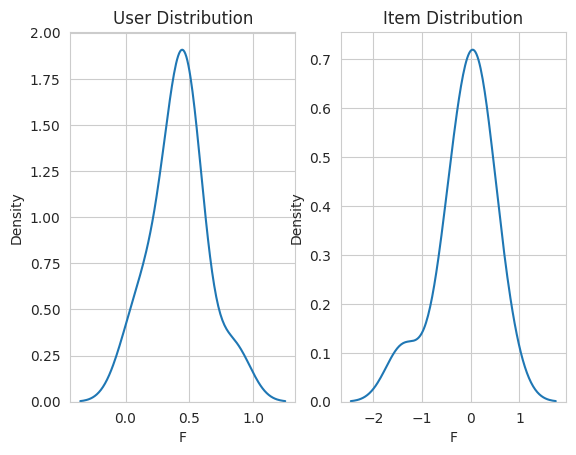

In [20]:
big_steps = 10
for i in range(big_steps):
    print(i)
    new_cust_distr, new_w_distr, _ = dynamic_system_iterate(model, new_cust_distr, new_w_distr, visualize_distributions=True)